# Hello! Welcome to this notebook!
## Today we are going to supose an Indian bank contacted us, and as Data Scientists, we need to analyze their data, group/segmentate their clients depending on their spending habits and obtain insights with conclussions.
## Hope you enjoy it!
## Let's start!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import scale
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import scale
from sklearn import decomposition as dc
from pca import pca
import warnings
import plotly.express as px
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
execfile(r'C:\Users\adrag\Desktop\Master Data Science UCM\Módulo minería de datos 1\NuestrasFunciones.py')

# Step 1 - Reading data, check nulls, check dtypes

In [3]:
credit = pd.read_csv("Credit card transactions - India - Simple.csv")

In [4]:
credit

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574
...,...,...,...,...,...,...,...
26047,26047,"Kolkata, India",22-Jun-14,Silver,Travel,F,128191
26048,26048,"Pune, India",3-Aug-14,Signature,Travel,M,246316
26049,26049,"Hyderabad, India",16-Jan-15,Silver,Travel,M,265019
26050,26050,"Kanpur, India",14-Sep-14,Silver,Travel,M,88174


In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      26052 non-null  int64 
 1   City       26052 non-null  object
 2   Date       26052 non-null  object
 3   Card Type  26052 non-null  object
 4   Exp Type   26052 non-null  object
 5   Gender     26052 non-null  object
 6   Amount     26052 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


### At first sight it looks obvious that the column Date has to be dtype Datetime.
### Appart from that Index can be eliminated
### The rest of the columns will be analyzed in the exploratory data analysis
### No nulls in this dataset, which is great

In [6]:
credit.Date = pd.to_datetime(credit.Date)

In [7]:
credit.drop("index",axis = 1,inplace = True)

In [8]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   City       26052 non-null  object        
 1   Date       26052 non-null  datetime64[ns]
 2   Card Type  26052 non-null  object        
 3   Exp Type   26052 non-null  object        
 4   Gender     26052 non-null  object        
 5   Amount     26052 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.2+ MB


# Step 2 - Exploratory Data Analysis (EDA)

## Let's start with the city variable

In [9]:
credit.City

0                 Delhi, India
1        Greater Mumbai, India
2             Bengaluru, India
3        Greater Mumbai, India
4             Bengaluru, India
                 ...          
26047           Kolkata, India
26048              Pune, India
26049         Hyderabad, India
26050            Kanpur, India
26051         Hyderabad, India
Name: City, Length: 26052, dtype: object

### We are going to check if all cities are from India, if not, it would be an outlier or wrong taken data, as this dataset is suposed to be all from India

In [10]:
#I will create a new variable named Country that will have the country of each observation
credit["Country"] = credit.City.apply(lambda x: x.split(",")[1])

In [11]:
credit.Country.value_counts()

Country
 India    26052
Name: count, dtype: int64

### Now we are sure all cities are from India, let's drop the new variable and transform the variable City, leaving only the city

In [12]:
credit.drop("Country",axis = 1,inplace = True)

In [13]:
credit["City"] = credit.City.apply(lambda x: x.split(",")[0])

In [14]:
credit.City

0                 Delhi
1        Greater Mumbai
2             Bengaluru
3        Greater Mumbai
4             Bengaluru
              ...      
26047           Kolkata
26048              Pune
26049         Hyderabad
26050            Kanpur
26051         Hyderabad
Name: City, Length: 26052, dtype: object

### Let's check the distribution of observations by city

In [15]:
credit.City.value_counts()

City
Bengaluru          3552
Greater Mumbai     3493
Ahmedabad          3491
Delhi              3482
Hyderabad           784
                   ... 
Rayagada              1
Varanasi              1
Hugli-Chinsurah       1
Alirajpur             1
Fazilka               1
Name: count, Length: 986, dtype: int64

In [16]:
credit["City"].value_counts()[credit["City"].value_counts() <740]

City
Ramnagar            19
Kalyan-Dombivali    19
Vijayapura          15
Udaipur             15
Pratapgarh          14
                    ..
Rayagada             1
Varanasi             1
Hugli-Chinsurah      1
Alirajpur            1
Fazilka              1
Name: count, Length: 974, dtype: int64

In [17]:
credit["City"].value_counts()[credit["City"].value_counts() >740]

City
Bengaluru         3552
Greater Mumbai    3493
Ahmedabad         3491
Delhi             3482
Hyderabad          784
Chennai            774
Kolkata            773
Kanpur             764
Lucknow            759
Jaipur             752
Surat              749
Pune               747
Name: count, dtype: int64

### Here there is a clear difference between cities, after looking for information about them, i soon realised the ones with over 700 appareances are big cities, with more than 4 million people each.
### The rest are smaller towns or cities, with less than 1 million people living each, many of whom has less than 50k habitants.
### It would be interesting to discover if the consumer habits of indian people could change if the transactions are done in a big city or in a small city.
### Let's create another variable "Big city" with a value of 1 or 0

In [18]:
credit["Big_city"] = credit["City"].replace(["Bengaluru","Greater Mumbai","Ahmedabad","Delhi","Hyderabad","Chennai","Kolkata","Kanpur","Lucknow","Jaipur","Surat","Pune"],1)

In [19]:
credit["Big_city"] = credit["Big_city"].apply(lambda x: 1 if x == 1 else 0)

In [20]:
credit.Big_city.value_counts()

Big_city
1    20120
0     5932
Name: count, dtype: int64

### It looks like even if we joined all small cities they still have less observations than the ones of big cities

### We are gonna end up deleting the variable City as we created the variable Big_city, which is more meaningful

In [21]:
credit.drop("City",axis = 1,inplace = True)

## Lets continue with Date variable

In [22]:
credit.Date

0       2014-10-29
1       2014-08-22
2       2014-08-27
3       2014-04-12
4       2015-05-05
           ...    
26047   2014-06-22
26048   2014-08-03
26049   2015-01-16
26050   2014-09-14
26051   2013-10-19
Name: Date, Length: 26052, dtype: datetime64[ns]

### Lets first check in number of transactions for each day

In [23]:
credit.Date.value_counts()

Date
2014-09-20    65
2013-12-21    61
2014-11-15    61
2014-08-11    61
2015-02-20    60
              ..
2014-08-29    27
2014-05-09    26
2014-02-28    25
2014-07-30    24
2015-04-11    23
Name: count, Length: 600, dtype: int64

<Axes: xlabel='Date'>

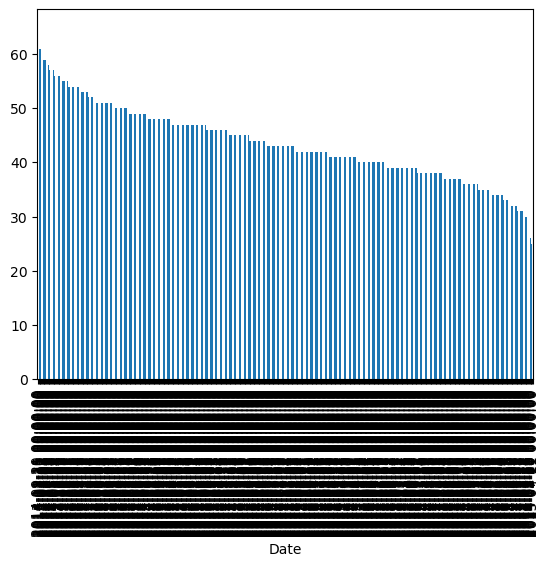

In [24]:
credit.Date.value_counts().plot(kind = "bar")

### Okay, we cant see nothing in this plot, but it looks kinda flat, lets check the minimum and maximum value

In [25]:
credit.Date.value_counts().min()

23

In [26]:
credit.Date.value_counts().max()

65

### Not a lot of difference in number of transactions, lets check the first top 10 number of transactions and its date

In [27]:
credit.Date.value_counts().sort_values(ascending= False).head(10)

Date
2014-09-20    65
2014-11-15    61
2014-08-11    61
2013-12-21    61
2015-02-20    60
2015-01-12    60
2015-02-07    59
2013-12-13    59
2014-04-03    59
2015-03-18    59
Name: count, dtype: int64

### Im not sure if something really special occurs on those days

### Let's continue with the Card Type

In [28]:
credit["Card Type"].value_counts()

Card Type
Silver       6840
Signature    6447
Platinum     6398
Gold         6367
Name: count, dtype: int64

### For sure this is a category, let's change dtype

In [29]:
credit["Card Type"] = credit["Card Type"].astype("category")

### Appart from that it looks so balanced the use of each one, let's see if there are differences with the amount spent

<Axes: xlabel='Card Type', ylabel='Amount'>

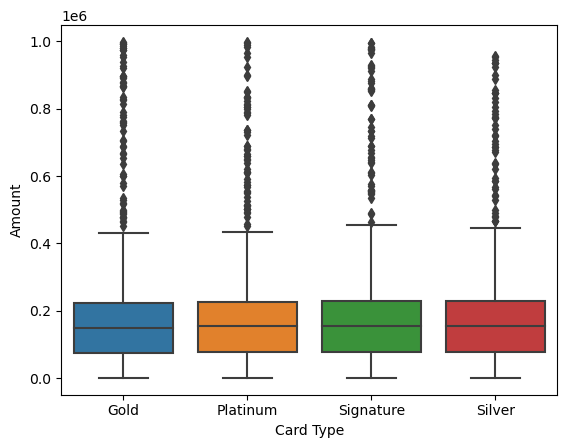

In [30]:
sns.boxplot(x  = credit["Card Type"], y = credit.Amount)

### This is so interesting, appart from lots of outliers there is almost no difference in the use of each type of card, let's compare between men and women

<Axes: xlabel='Card Type', ylabel='Amount'>

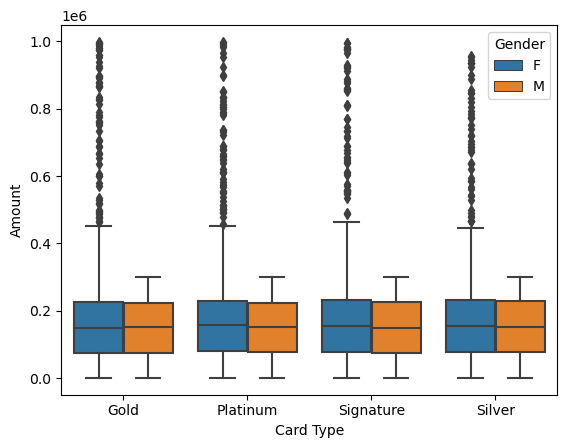

In [31]:
sns.boxplot(x  = credit["Card Type"], y = credit.Amount, hue = credit.Gender)

### Here we just discovered an amazing insight, even if the median and until 75% of the amount spent is more or less the same, some women tend to spend incredible amounts of money, considered outliers by this boxplot

### To finish wiht this card type, lets see if there is any difference about the city they belong to.

<Axes: xlabel='Big_city'>

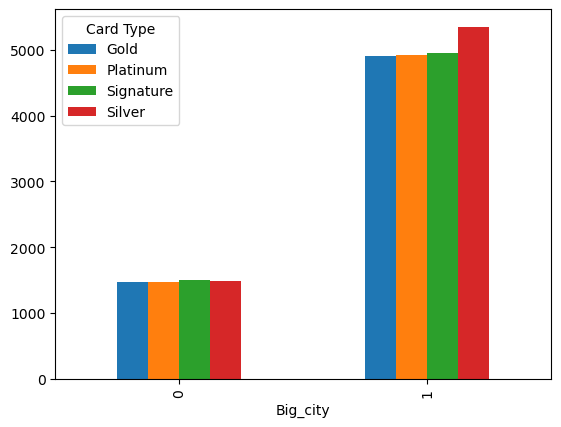

In [32]:
credit.groupby("Big_city")["Card Type"].value_counts().unstack().plot(kind = "bar")

### It is normal that more cards are in the big cities, but it looks like are more or less the same.

## Variable Exp Type

In [33]:
credit["Exp Type"].value_counts()

Exp Type
Food             5463
Fuel             5257
Bills            5078
Entertainment    4762
Grocery          4754
Travel            738
Name: count, dtype: int64

### This is also a category, lets change its dtype

In [34]:
credit["Exp Type"] = credit["Exp Type"].astype("category")

### Let's see how much money they spent on each category

<Axes: xlabel='Exp Type', ylabel='Amount'>

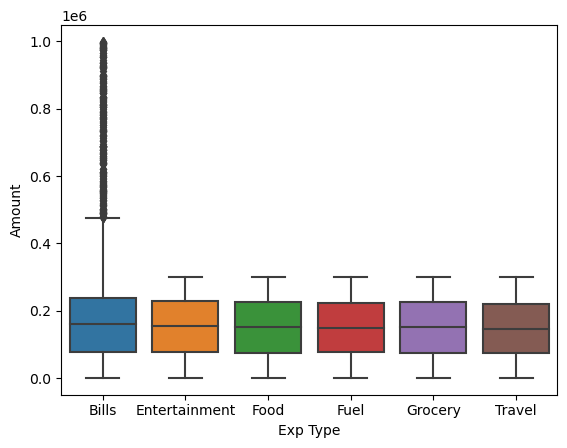

In [35]:
sns.boxplot(x  = credit["Exp Type"], y = credit.Amount)

### Here we have 2 interesting insights, first of all the bills, it has a lot of outliers, meaning the costs are higher. Another interesting insight is Travel, as it only has 738 observations, the amount spent is more or less the same as the others

### Lets see about the card type

<Axes: xlabel='Exp Type'>

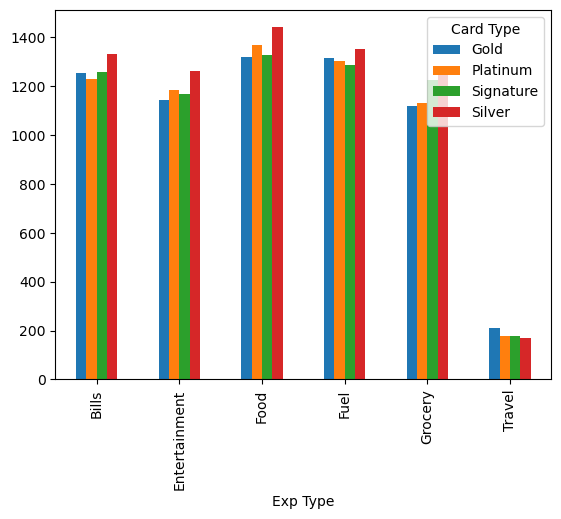

In [36]:
credit.groupby("Exp Type")["Card Type"].value_counts().unstack().plot(kind = "bar")

### More or less the same,it looks in general terms Silver Card is used more in general except Travel

## Variable Gender

In [37]:
credit.Gender.value_counts()

Gender
F    13680
M    12372
Name: count, dtype: int64

### Balanced, let's change the dtype to category

In [38]:
credit.Gender = credit.Gender.astype("category")

### We already checked the money spent and the card type used. We are going to check if differences can appear deppending on the city

<Axes: xlabel='Big_city', ylabel='Amount'>

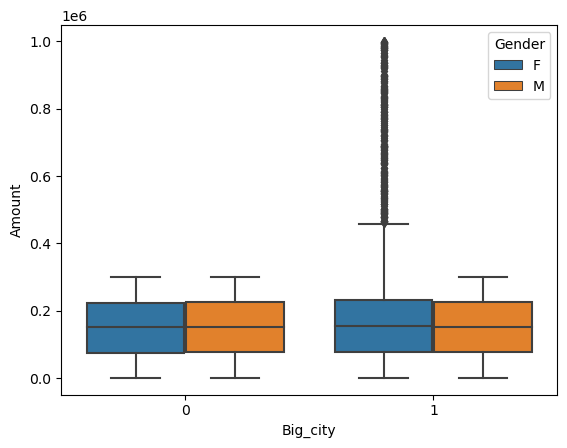

In [39]:
sns.boxplot(x = credit["Big_city"],y = credit.Amount, hue = credit.Gender)

### This is so impressive, here we can take an amazing insight. Women and men tend to pay the same in small cities, but in big cities the females tend to make higher transactions, men tend to pay the same

## Variable Amount

In [40]:
credit.Amount

0         82475
1         32555
2        101738
3        123424
4        171574
          ...  
26047    128191
26048    246316
26049    265019
26050     88174
26051    184410
Name: Amount, Length: 26052, dtype: int64

### Lets check if there are differences in the total amount by men and women

In [41]:
credit.groupby("Gender")["Amount"].sum()

Gender
F    2205311030
M    1869522343
Name: Amount, dtype: int64

### It looks like women in general has a higher amount spent, but the difference is not really big

### Now we are going to check amount over the time

In [42]:
credit.groupby("Date")["Amount"].sum()

Date
2013-10-04    9738755
2013-10-05    8062632
2013-10-06    6990055
2013-10-07    7822992
2013-10-08    5832533
               ...   
2015-05-22    6613863
2015-05-23    6393798
2015-05-24    7171912
2015-05-25    5176669
2015-05-26    7591837
Name: Amount, Length: 600, dtype: int64

<Axes: xlabel='Date'>

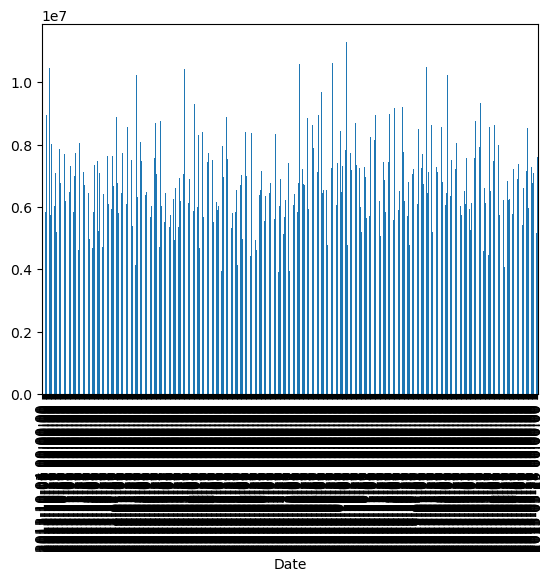

In [43]:
credit.groupby("Date")["Amount"].sum().plot(kind = "bar")

### This graphic is again difficult to check, altough we can imagine that is kinda flat, except for some values that exceed 10M

### Lets check the first 10 values

In [44]:
credit.groupby("Date")["Amount"].sum().sort_values(ascending = False).head(10)

Date
2014-10-07    11282456
2014-09-20    10627971
2014-08-11    10581084
2015-01-12    10498169
2013-10-13    10439795
2014-03-25    10433999
2015-02-06    10233778
2014-01-26    10226607
2015-01-16    10111932
2015-04-28     9981496
Name: Amount, dtype: int64

### Lets now plot it over the time to check any kind of trend or seasoning

<Axes: xlabel='Date', ylabel='Amount'>

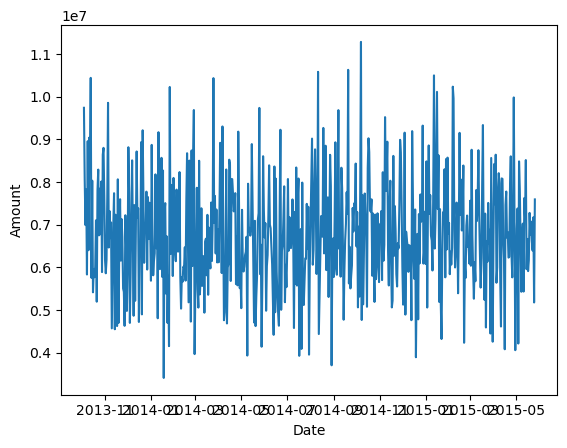

In [45]:
sns.lineplot(credit.groupby("Date")["Amount"].sum())

### So confusing, at least something is clear, it doesnt look to have any trend up or down. Lets group it by month and check again

In [46]:
#Creation of a new variable were we are going to select only the month
credit["Date_month"] = credit.Date.astype("object")

In [47]:
credit["Date_month"] = credit["Date_month"].apply(lambda x: str(x)[:7])

In [48]:
credit["Date_month"] = pd.to_datetime(credit["Date_month"])

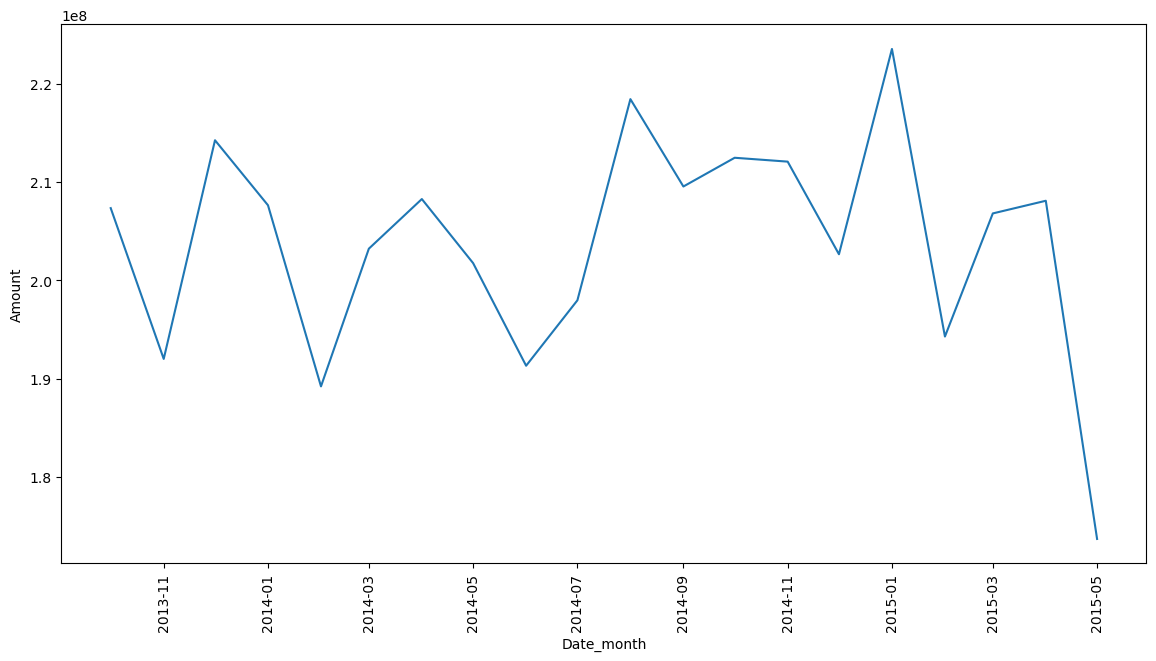

In [49]:
plt.figure(figsize=(14, 7))
sns.lineplot(credit.groupby("Date_month")["Amount"].sum())
plt.xticks(rotation=90)
plt.show()

### Difficult to bring any insights except for that drop in amount spent in May 2015

### Lets check if there is any trend were people did more number of transactions, forgetting about the amount of  money spent

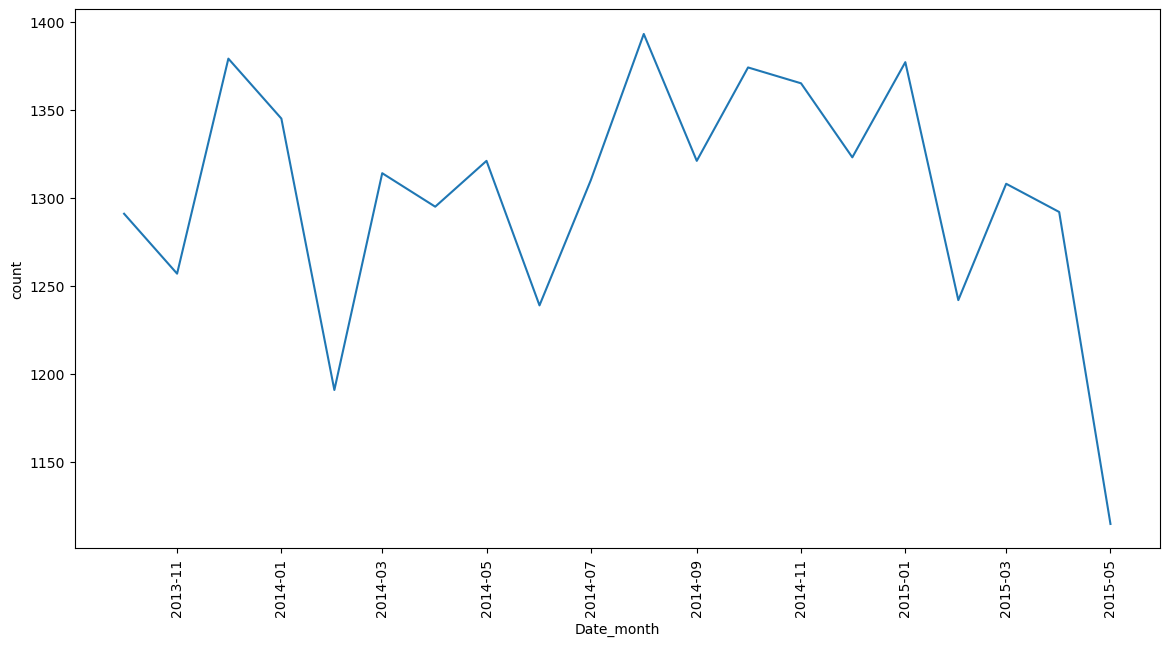

In [50]:
plt.figure(figsize=(14, 7))
sns.lineplot(credit.Date_month.value_counts())
plt.xticks(rotation=90)
plt.show()

### I cant see any kind of trend or seasoning in any of both plots, it can be normal as we are taking just one and half year

### Variable Date cant give us any kind of information so we wont use it on the models

In [51]:
credit.drop(["Date","Date_month"],axis = 1,inplace = True)

# Conclussion of the EDA:
## City: Changed to Big city (1) and Small city (0), more transactions done in Big cities than small cities.
## Card type: No differences in the amount spent or number of transactions
## Exp type: No differences in the amount spent or number of transactions, except for travel that has lower number of transactions and for Bills that has lots of outliers in amount
## Gender: Balanced number of transactions for men and women, the most important insight is that woman tend to spend more in bills when they are in big cities
## Amount: No trends or seasonality in this time period. Women paid total amount higher than men, but not a huge difference

In [52]:
#This is the final dataset we will use for customer segmentation
credit

,Card Type,Exp Type,Gender,Amount,Big_city
0,Gold,Bills,F,82475,1
1,Platinum,Bills,F,32555,1
2,Silver,Bills,F,101738,1
3,Signature,Bills,F,123424,1
4,Gold,Bills,F,171574,1
...,...,...,...,...,...
26047,Silver,Travel,F,128191,1
26048,Signature,Travel,M,246316,1
26049,Silver,Travel,M,265019,1
26050,Silver,Travel,M,88174,1


# Step 3 - Process and scale data

### First, we are going to use LabelEncoder as we have categorical data, it will be needed to transform it to numeric
### Then, apply dummy to the binary category
### Lastly scale data, as clustering works with distances in the space

In [59]:
le = LabelEncoder()
credit_encoded = credit.copy()
credit_encoded['Card Type'] = le.fit_transform(credit['Card Type'])
credit_encoded['Exp Type'] = le.fit_transform(credit['Exp Type'])

In [60]:
credit_encoded["Gender"] = pd.get_dummies(credit["Gender"],drop_first = True)

In [61]:
credit_encoded.replace([False,True],[0,1],inplace = True)

In [62]:
credit_encoded_std = scale(credit_encoded)

In [63]:
credit_encoded_std = pd.DataFrame(credit_encoded_std)
credit_encoded_std.columns = ["Card Type","Exp Type","Gender","Amount","Big_city"]

In [64]:
credit_encoded_std

,Card Type,Exp Type,Gender,Amount,Big_city
0,-1.359734,-1.420300,-0.950992,-0.717404,0.542983
1,-0.469957,-1.420300,-0.950992,-1.201776,0.542983
2,1.309596,-1.420300,-0.950992,-0.530495,0.542983
3,0.419819,-1.420300,-0.950992,-0.320077,0.542983
4,-1.359734,-1.420300,-0.950992,0.147121,0.542983
...,...,...,...,...,...
26047,1.309596,1.995343,-0.950992,-0.273823,0.542983
26048,0.419819,1.995343,1.051533,0.872340,0.542983
26049,1.309596,1.995343,1.051533,1.053814,0.542983
26050,1.309596,1.995343,1.051533,-0.662106,0.542983


# Step 4 - Looking for number of clusters

### In this step we are going to plot the distance intracluster with different numbers of clusters.
### The optimal number of clusters is going to be decided by the "elbow" method.
### As we have mixed data (categorical and numeric columns) we are going to choose KPrototypes

In [95]:
#Choosing optimal K
cost = []
for num_clusters in list(range(1,11)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(credit_encoded_std,categorical = [0,1,2,4])
    cost.append(kproto.cost_)

plt.plot(cost)

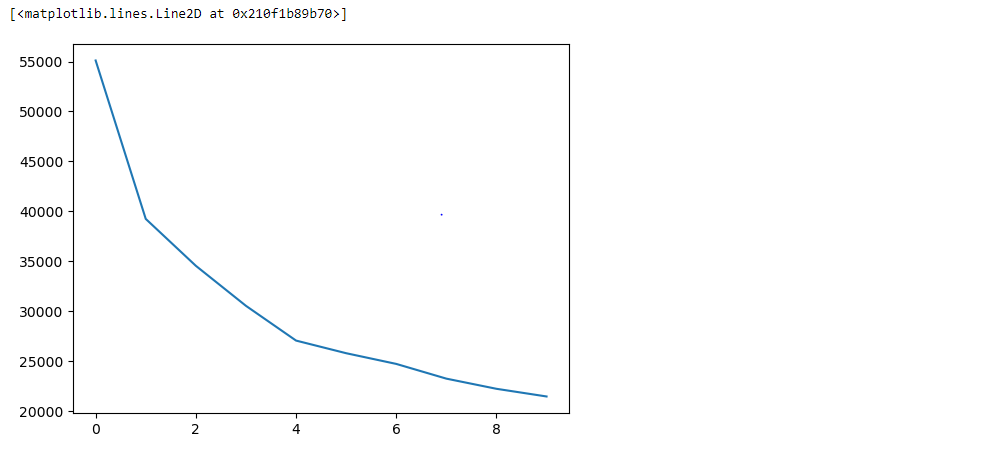

### According to this plot we are going to take 4 clusters

# Step 5 - PCA

### As we have lots of columns in our data, it will be needed to apply PCA in order to better understand  this clustering model. 
### This PCA will be represented in a 3D biplot

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,Card Type,Exp Type,Gender,Amount,Big_city
PC1,0.171980,-0.525640,-0.504934,0.638724,0.176634
PC2,-0.343956,-0.534565,0.293539,0.080918,-0.709381
PC3,-0.856356,0.066347,0.104131,0.246799,0.436463


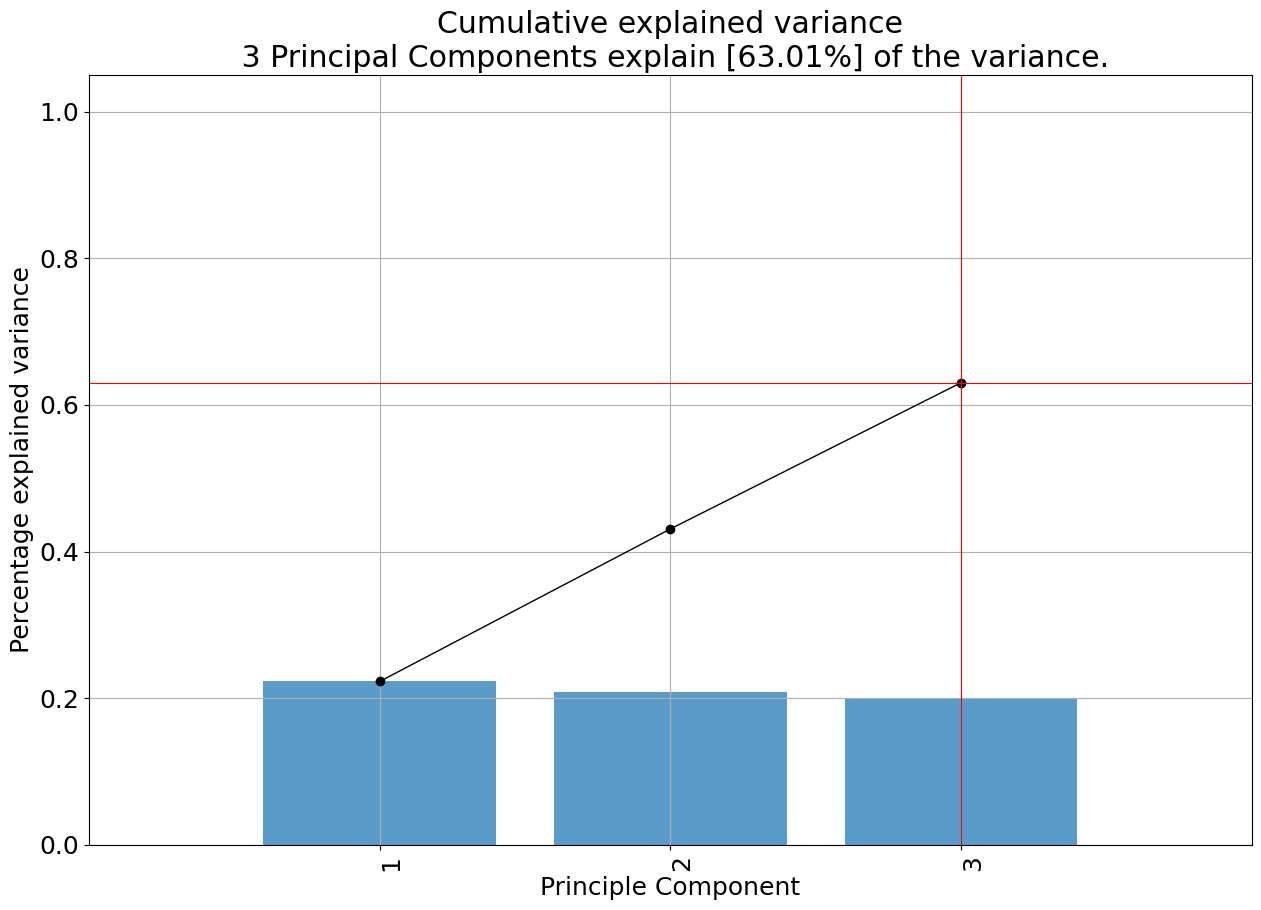

In [76]:
# Initialize pca with default parameters
pcaModel = pca(normalize=True,n_components=3)
results = pcaModel.fit_transform(credit_encoded_std)
pcaModel.plot()
# Análisis de cargas
pcaModel.results['loadings']

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes3D: title={'center': '3 Principal Components explain [63.01%] of the variance'}, xlabel='PC1 (22.2% expl.var)', ylabel='PC2 (20.7% expl.var)', zlabel='PC3 (19.9% expl.var)'>)

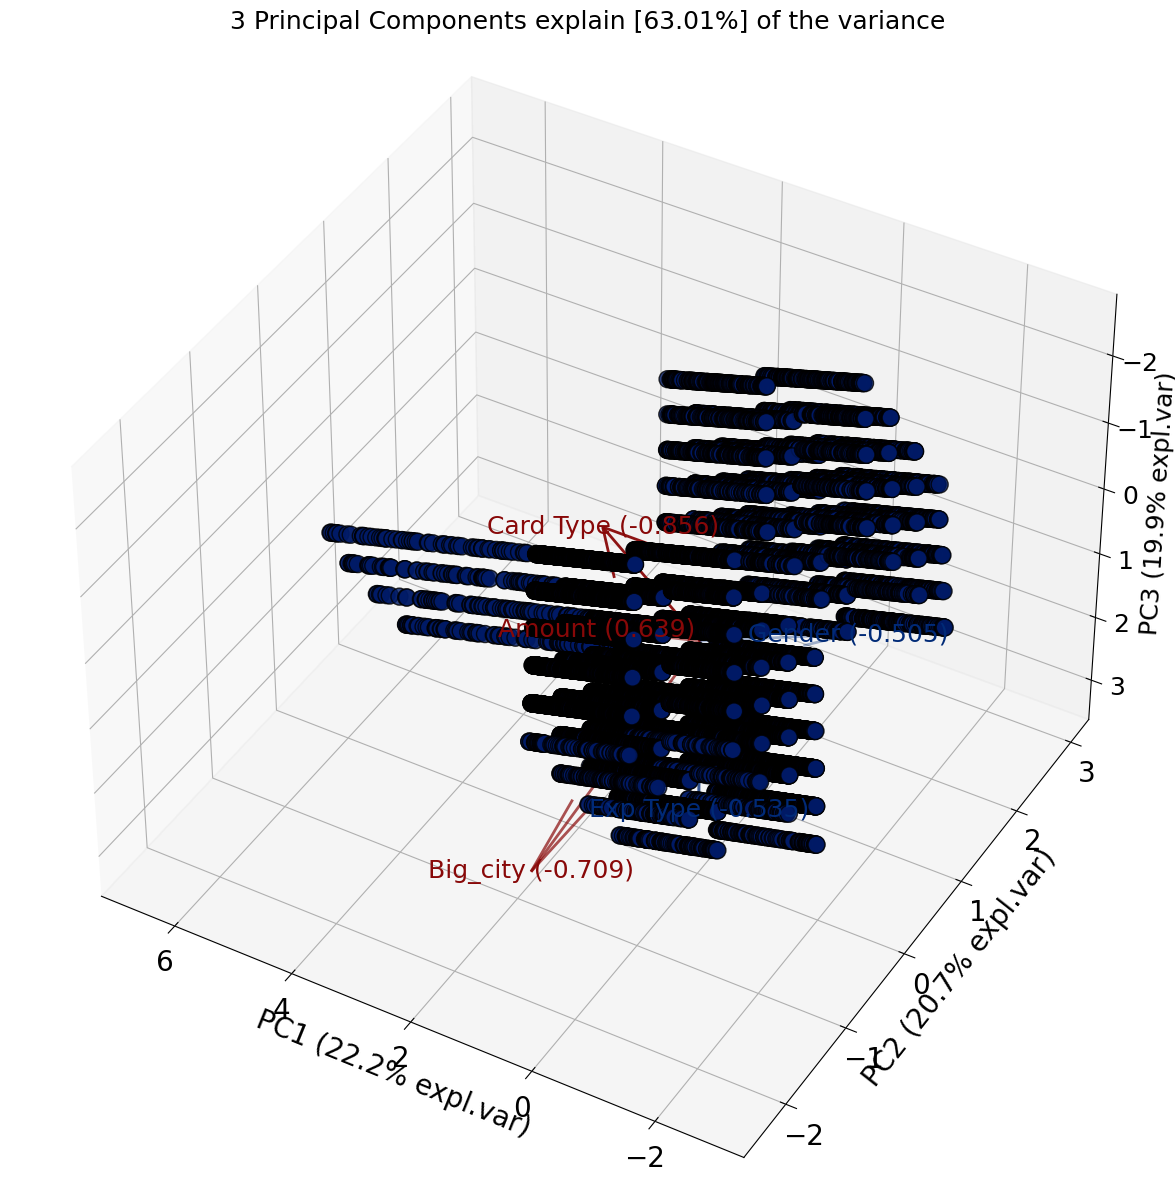

In [77]:
pcaModel.biplot(PC = [0, 1, 2])

### It is not bad, this 3D PCA explains 63% of the data, but even with the 3D biplot is difficult to determine something.
### Let's create the clustering model and then plot it to understand everything better

# Step 6 - KPrototypes

### Applying Kmeans won't be a great idea as we have categorical and numerical data in our dataset, thats why we are going to implement KPrototypes model, which is able to work with mixed data

In [72]:
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
kproto.fit(credit_encoded_std,categorical = [0,1,2,4])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3254, ncost: 33039.74594675027
Run: 1, iteration: 2/100, moves: 970, ncost: 33002.43897171322
Run: 1, iteration: 3/100, moves: 555, ncost: 32989.67777883694
Run: 1, iteration: 4/100, moves: 288, ncost: 32986.300391301294
Run: 1, iteration: 5/100, moves: 196, ncost: 32984.768189758215
Run: 1, iteration: 6/100, moves: 110, ncost: 32984.065275345
Run: 1, iteration: 7/100, moves: 91, ncost: 32983.7107632809
Run: 1, iteration: 8/100, moves: 42, ncost: 32983.60847714462
Run: 1, iteration: 9/100, moves: 34, ncost: 32983.540355126
Run: 1, iteration: 10/100, moves: 28, ncost: 32983.49392545659
Run: 1, iteration: 11/100, moves: 28, ncost: 32983.44532731003
Run: 1, iteration: 12/100, moves: 18, ncost: 32983.42637171156
Run: 1, iteration: 13/100, moves: 12, ncost: 32983.41784722491
Run: 1, iteration: 14/100, mov

KPrototypes(gamma=0.5, n_clusters=4, verbose=2)

In [73]:
cluster_kproto=kproto.labels_

In [78]:
# Creation of the dataset joining the PC1,PC2,PC3 of the PCA and the cluster labels we saved earlier
nuevo_conjunto = pcaModel.results['PC'].join(pd.DataFrame(cluster_kproto))

### Now let's plot the previous PCA with the colors of the groups created by KPrototypes

In [89]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=0)
#fig.show()

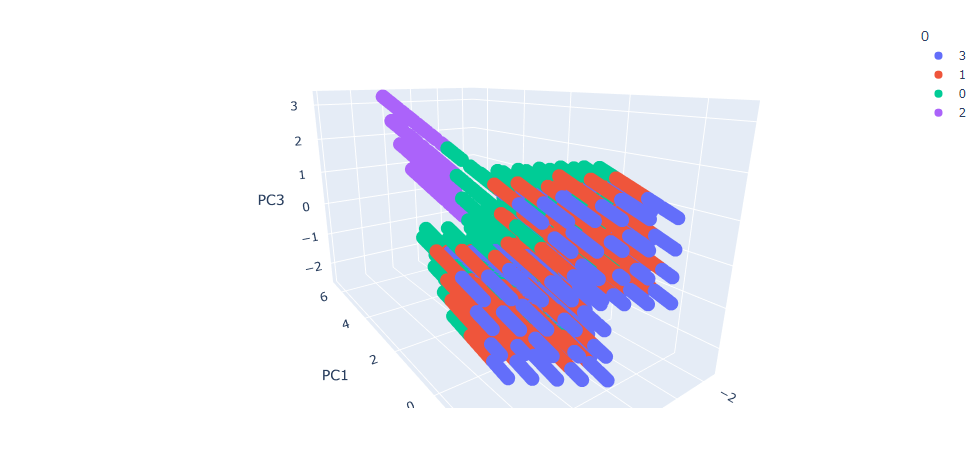

### In general terms this plot seem to have well diferenciated groups, with enaugh observations for each group
### Lets plot this same PCA but with the colors of the variables to fully understand this groups made by KPrototypes

# Step 7 - Plots and conclussions

### Let's start with the Card Type

In [90]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_encoded_std["Card Type"])
#fig.show()

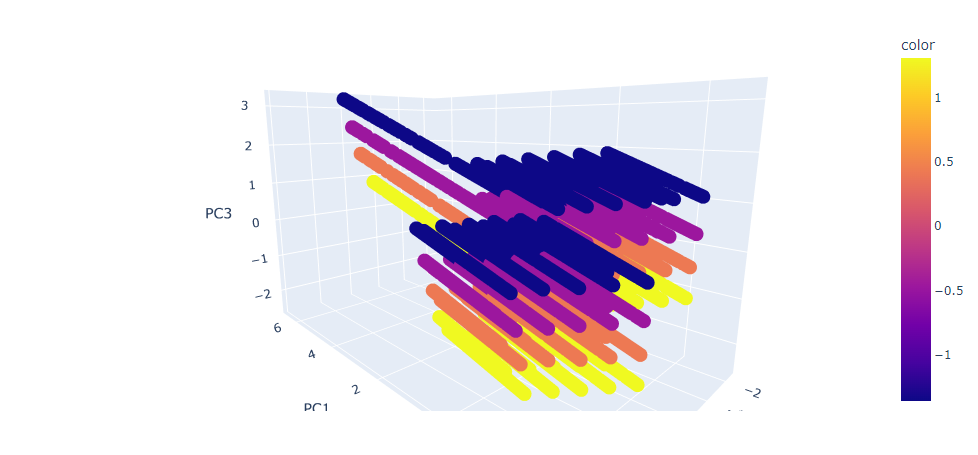

### Now the gender

In [91]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_encoded_std["Gender"])
#fig.show()

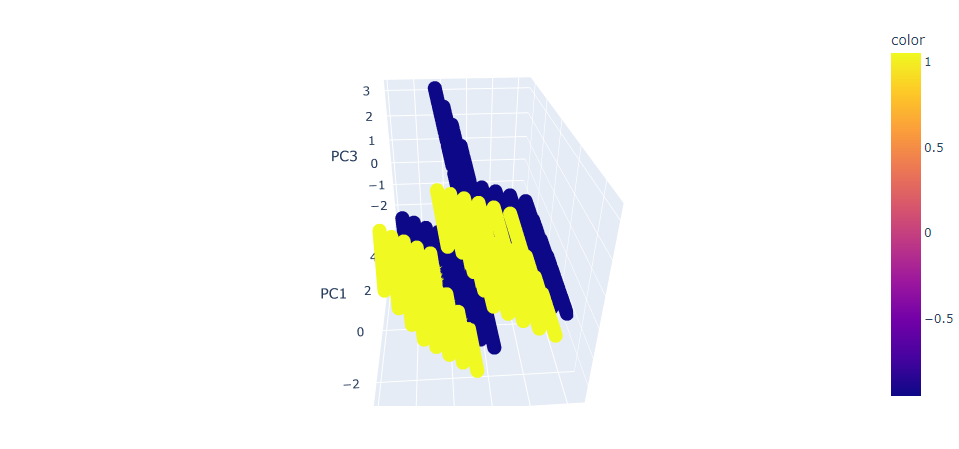

### Amount

In [92]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_encoded_std["Amount"])
#fig.show()

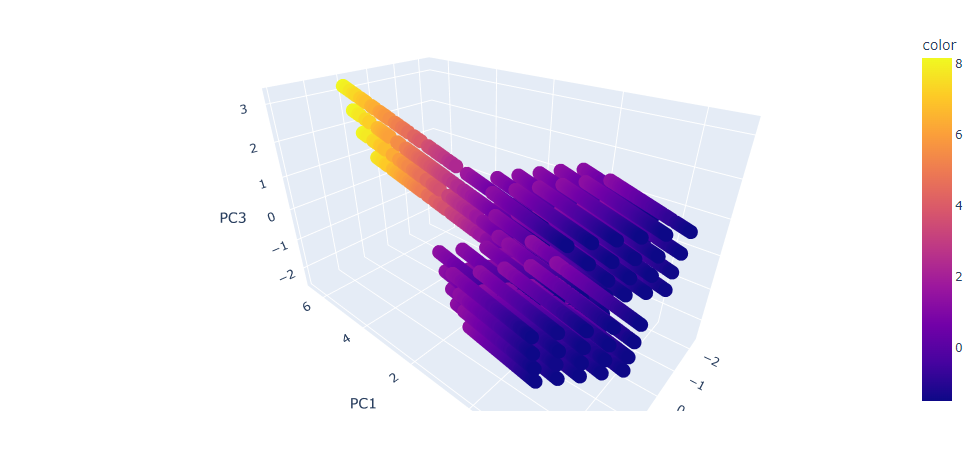

### If they are in a big city 

In [93]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_encoded_std["Big_city"])
#fig.show()

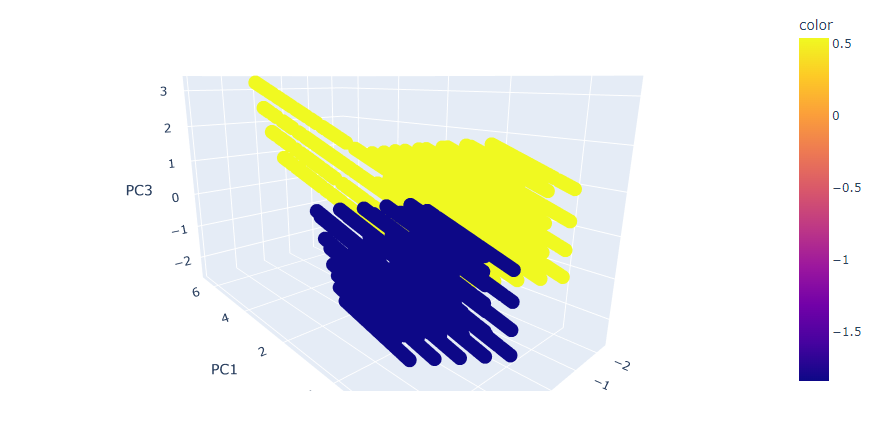

### Exp Type

In [94]:
#fig = px.scatter_3d(nuevo_conjunto, x='PC1',y='PC2', z='PC3', color=credit_encoded_std["Exp Type"])
#fig.show()

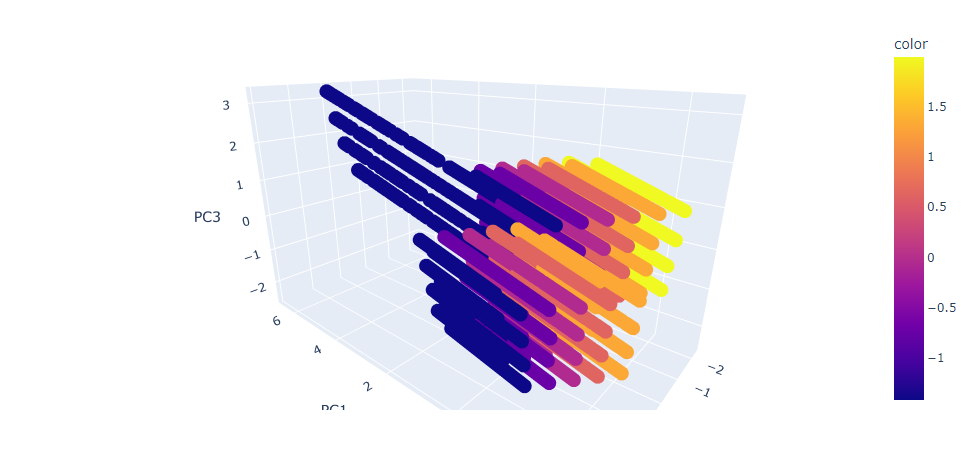

# Conclussions

### In general terms the groups are made mainly taking into account the amount spent.
### No differences between Exp Type, Big_city, Gender or Card Type.
### So the groups are:
### * Group 1: Women, Big cities, spending greats amount of money for Bills, doesnt matter the Card Type.
### * Group 2: Men and Women, Big and small cities, paying all kind of Exp Type and using all types of Card, spending medium-high amounts of money.
### * Group 3: Men and Women, Big and small cities, paying all kind of Exp Type and using all types of Card, spending medium amount of money.
### * Group 4: Men and Women, Big and small cities, paying all kind of Exp Type and using all types of Card, spending low amounts of money.